In [5]:
import pandas as pd
import sqlite3
import os 
import sys

In [6]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
   sys.path.append(project_root)

In [7]:
from source.utils.minio_helper import read_df_from_minio

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print(f"✅ Project Root set to: {project_root}")

✅ Project Root set to: d:\Other\BI-UAS\mobile-legends-draft-assistant


In [31]:
BUCKET_NAME = "mlbb-lake"

# Peta Lokasi File (Sesuaikan path ini dengan path aktual di MinIO Anda)
DATA_SOURCES = {
   "STATS_RAW": "raw/temp/hero_master/statistik_hero_raw.csv",
   "SQL_INTERNAL": "raw/internal_db/hero_master_sql.csv",      # Sumber 1: Mock SQL
   "SPREADSHEET_ID": "raw/mpl_matches/mpl_id_s16.csv",          # Sumber 2: CSV MPL S16
   "SPREADSHEET_PH": "raw/mpl_matches/mpl_ph_s16.csv",          # Sumber 2: CSV MPL S16
   "COUNTER_TIER_RAW": "raw/counter/data_counter.csv",  # Sumber 3: Web Scraping Stats
   "META_RAW": "raw/hero_meta/meta_tier_raw.csv",         # Sumber 4: Web Scraping Tier
}

In [10]:
def check_data(bucket_name, file_path, label):
   df = read_df_from_minio(bucket_name, file_path)
   
   if df is None:
      print('Gagal membaca file {file_path}')
   
   print(f'{df.shape[0]} baris, {df.shape[1]} kolom')
   
   # check missing values dan duplikt
   missing = df.isnull().sum()
   duplicates = df.duplicated().sum()
   
   # check tipe data untuk silver layer
   print(df.dtypes)
   
   display(df.head)
   
   potential_numeric_issues = []
   for col in df.select_dtypes(include='object').columns:
      # Cek sampel data
      sample = df[col].dropna().astype(str).iloc[0] if not df[col].dropna().empty else ""
      if "%" in sample:
         potential_numeric_issues.append(col)
         
   if potential_numeric_issues:
      print(f"\nKolom berikut mengandung '%' (Perlu cleaning): {potential_numeric_issues}")
      
   return df

In [17]:
df_stats = check_data(BUCKET_NAME, DATA_SOURCES["STATS_RAW"], "HERO STATISTICS (SCRAPING)")

# Visual Check: Apakah ada hero duplikat?
if df_stats is not None:
   duplicate_heroes = df_stats[df_stats.duplicated(subset=['Nama Hero'], keep=False)]
   if not duplicate_heroes.empty:
      print("⚠️ Ditemukan nama hero ganda:")
      display(duplicate_heroes)
   else:
      print("✅ Nama Hero Unik (Aman sebagai Primary Key).")

130 baris, 10 kolom
Hero ID         int64
Nama Hero      object
Win Rate       object
Pick Rate      object
Ban Rate       object
Speciality     object
Rank Filter    object
Timeframe      object
Data Date      object
Image URL      object
dtype: object


<bound method NDFrame.head of      Hero ID Nama Hero Win Rate Pick Rate Ban Rate             Speciality Rank Filter   Timeframe                 Data Date                                          Image URL
0        109     Aamon   53.34%     1.04%   50.16%    Chase, Magic Damage         ALL  Past 1 day  2025-12-18T13:00:26.000Z  https://akmweb.youngjoygame.com/web/svnres/img...
1          9      Akai   49.35%     0.43%    1.62%   Guard, Crowd Control         ALL  Past 1 day  2025-12-18T13:00:26.000Z  https://akmweb.youngjoygame.com/web/svnres/img...
2         64    Aldous   48.65%      0.4%    0.56%         Burst, Support         ALL  Past 1 day  2025-12-18T13:00:26.000Z  https://akmweb.youngjoygame.com/web/svnres/img...
3          4     Alice   51.42%     0.82%   36.09%          Charge, Regen         ALL  Past 1 day  2025-12-18T13:00:26.000Z  https://akmweb.youngjoygame.com/web/svnres/img...
4         28     Alpha   50.61%      1.8%    2.37%         Charge, Damage         ALL  Past 1 d


Kolom berikut mengandung '%' (Perlu cleaning): ['Win Rate', 'Pick Rate', 'Ban Rate']
✅ Nama Hero Unik (Aman sebagai Primary Key).


In [23]:
df_sql = check_data(BUCKET_NAME, DATA_SOURCES["SQL_INTERNAL"], "INTERNAL SQL DATABASE")

# Cross-Check: Apakah nama hero di SQL sama persis dengan Scraping?
if df_stats is not None and df_sql is not None:
    # Asumsi kolom nama di SQL adalah 'hero_name' dan di Scraping 'Nama Hero'
    # Sesuaikan nama kolom jika berbeda
    stats_heroes = set(df_stats['Nama Hero'])
    sql_heroes = set(df_sql['hero_name']) # Ubah 'hero_name' sesuai kolom SQL Anda
    
    diff = stats_heroes - sql_heroes
    print(f"\n🔄 Konsistensi Data:")
    print(f"Hero di Scraping tapi tidak ada di SQL: {len(diff)}")
    if len(diff) > 0:
        print(list(diff)[:5])

130 baris, 5 kolom
hero_name     object
win_rate      object
pick_rate     object
ban_rate      object
speciality    object
dtype: object


<bound method NDFrame.head of     hero_name win_rate pick_rate ban_rate             speciality
0       Aamon   53.34%     1.04%   50.16%    Chase, Magic Damage
1        Akai   49.35%     0.43%    1.62%   Guard, Crowd Control
2      Aldous   48.65%      0.4%    0.56%         Burst, Support
3       Alice   51.42%     0.82%   36.09%          Charge, Regen
4       Alpha   50.61%      1.8%    2.37%         Charge, Damage
..        ...      ...       ...      ...                    ...
125       Yve   53.61%     0.27%    1.01%            Poke, Burst
126    Zetian   49.64%     0.86%    4.33%  Damage, Crowd Control
127     Zhask   49.53%     0.29%     0.4%          Chase, Damage
128    Zhuxin   50.24%     0.32%    3.45%  Damage, Crowd Control
129    Zilong   47.17%      0.8%     0.6%          Chase, Damage

[130 rows x 5 columns]>


Kolom berikut mengandung '%' (Perlu cleaning): ['win_rate', 'pick_rate', 'ban_rate']

🔄 Konsistensi Data:
Hero di Scraping tapi tidak ada di SQL: 0


In [38]:
df_stats['Speciality'].head()

0     Chase, Magic Damage
1    Guard, Crowd Control
2          Burst, Support
3           Charge, Regen
4          Charge, Damage
Name: Speciality, dtype: object

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

130 baris, 6 kolom
Hero ID            int64
Nama Hero         object
Tier              object
Previous Tier     object
Score            float64
Image URL         object
dtype: object


<bound method NDFrame.head of      Hero ID    Nama Hero Tier Previous Tier     Score                                          Image URL
0        104         Gloo   SS            SS  1057.740  https://akmweb.youngjoygame.com/web/svnres/img...
1        109        Aamon   SS            SS   878.088  https://akmweb.youngjoygame.com/web/svnres/img...
2         55       Angela   SS            SS   860.798  https://akmweb.youngjoygame.com/web/svnres/img...
3         30  Yi Sun-shin   SS            SS   835.917  https://akmweb.youngjoygame.com/web/svnres/img...
4         21     Hayabusa   SS            SS   834.341  https://akmweb.youngjoygame.com/web/svnres/img...
..       ...          ...  ...           ...       ...                                                ...
125       73       Harith    D             D   140.374  https://akmweb.youngjoygame.com/web/svnres/img...
126       85      Dyrroth    D             D   140.205  https://akmweb.youngjoygame.com/web/svnres/img...
127      103    

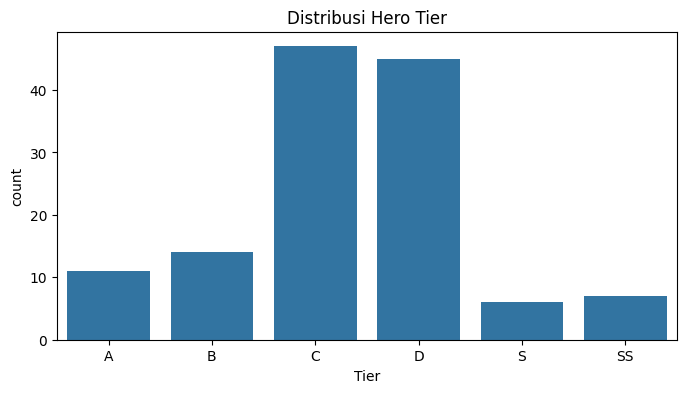

In [27]:
df_meta = check_data(BUCKET_NAME, DATA_SOURCES["META_RAW"], "META & TIER (SCRAPING)")

if df_meta is not None:
   # Visualisasi Cepat: Distribusi Tier
   plt.figure(figsize=(8, 4))
   sns.countplot(data=df_meta, x='Tier', order=sorted(df_meta['Tier'].unique()))
   plt.title("Distribusi Hero Tier")
   plt.show()

In [39]:
df_counter_tier = check_data(BUCKET_NAME, DATA_SOURCES["COUNTER_TIER_RAW"], "SPREADSHEET MPL S16")

print(df_counter_tier)

1435 baris, 8 kolom
Target_ID         int64
Target_Name      object
Counter_Name     object
Score           float64
Tier             object
Role             object
Lane             object
Speciality       object
dtype: object


<bound method NDFrame.head of       Target_ID Target_Name    Counter_Name  Score Tier           Role               Lane            Speciality
0             1        Miya        Belerick  6.949    B           Tank               Roam  Crowd Control, Regen
1             1        Miya       Gatotkaca  4.375    C  Tank, Fighter     Roam, Exp Lane  Crowd Control, Burst
2             1        Miya          Thamuz  3.849    B        Fighter           Exp Lane         Chase, Damage
3             1        Miya           Baxia  3.518    D           Tank             Jungle       Support, Damage
4             1        Miya         Terizla  2.410    D  Fighter, Tank           Exp Lane  Burst, Crowd Control
...         ...         ...             ...    ...  ...            ...                ...                   ...
1430        130     Obsidia  Popol and Kupa  1.722    C       Marksman  Jungle, Gold Lane           Push, Burst
1431        130     Obsidia         Faramis  0.212    D  Support, Mage    

      Target_ID Target_Name    Counter_Name  Score Tier           Role               Lane            Speciality
0             1        Miya        Belerick  6.949    B           Tank               Roam  Crowd Control, Regen
1             1        Miya       Gatotkaca  4.375    C  Tank, Fighter     Roam, Exp Lane  Crowd Control, Burst
2             1        Miya          Thamuz  3.849    B        Fighter           Exp Lane         Chase, Damage
3             1        Miya           Baxia  3.518    D           Tank             Jungle       Support, Damage
4             1        Miya         Terizla  2.410    D  Fighter, Tank           Exp Lane  Burst, Crowd Control
...         ...         ...             ...    ...  ...            ...                ...                   ...
1430        130     Obsidia  Popol and Kupa  1.722    C       Marksman  Jungle, Gold Lane           Push, Burst
1431        130     Obsidia         Faramis  0.212    D  Support, Mage           Mid Lane         Guard,

In [35]:
df_mpl_id = check_data(BUCKET_NAME, DATA_SOURCES["SPREADSHEET_ID"], "SPREADSHEET MPL S16")

if df_mpl_id is not None and df_stats is not None:
    mpl_count = len(df_mpl_id)
    
    print(f"Jumlah Match MPL ID Dataset: {mpl_count}")

170 baris, 9 kolom
Match_Order      int64
Game_Number      int64
Team_Left       object
Team_Right      object
Winner_Match    object
Left_Bans       object
Left_Picks      object
Right_Bans      object
Right_Picks     object
dtype: object


<bound method NDFrame.head of      Match_Order  Game_Number           Team_Left               Team_Right             Winner_Match                                          Left_Bans                                         Left_Picks                                         Right_Bans                                        Right_Picks
0              1            1            ONICONIC          Dewa UnitedDEWA                 ONICONIC    Wanwan 2025, Yi Sun-Shin, Fanny, Selena, Uranus              Cici, Joy, Pharsa, Claude 2024, Hylos  Zhuxin, Kalea, Phoveus 2024, Bruno 2023, Grang...  Esmeralda, Lancelot 2021, Helcurt 2024, Harith...
1              1            2            ONICONIC          Dewa UnitedDEWA                 ONICONIC         Phoveus 2024, Fanny, Arlott, Uranus, Hilda  Cici, Lancelot 2021, Pharsa, Granger 2024, Gat...  Yi Sun-Shin, Wanwan 2025, Zhuxin, Harith, Mosk...        Esmeralda, Joy, Kagura 2021, Kalea, Beatrix
2              2            1   Natus VincereNAVI         

Jumlah Match MPL ID Dataset: 170


In [37]:
df_mpl_ph = check_data(BUCKET_NAME, DATA_SOURCES["SPREADSHEET_PH"], "SPREADSHEET MPL PH S16")

if df_mpl_ph is not None and df_stats is not None:
   mpl_count = len(df_mpl_ph)
   
   print(f"Jumlah Match MPL PH Dataset: {mpl_count}")

141 baris, 9 kolom
Match_Order      int64
Game_Number      int64
Team_Left       object
Team_Right      object
Winner_Match    object
Left_Bans       object
Left_Picks      object
Right_Bans      object
Right_Picks     object
dtype: object


<bound method NDFrame.head of      Match_Order  Game_Number           Team_Left            Team_Right          Winner_Match                                          Left_Bans                                         Left_Picks                                         Right_Bans                                        Right_Picks
0              1            1    Omega EsportsOMG       TNC Pro TeamTNC      Omega EsportsOMG           Baxia, Cici, Zhuxin, Fredrinn, Akai 2022            Lapu-Lapu, Fanny, Pharsa, Karrie, Kalea  Wanwan 2025, Yi Sun-Shin, Lancelot 2021, Chou,...       Arlott, Joy, Selena, Granger 2024, Gatotkaca
1              1            2    Omega EsportsOMG       TNC Pro TeamTNC      Omega EsportsOMG  Wanwan 2025, Yi Sun-Shin, Lancelot 2021, Khufr...            Hilda, Fanny, Pharsa, Harith, Gatotkaca                Kalea, Zhuxin, Uranus, Chou, Badang  Lapu-Lapu, Hayabusa 2021, Kimmy 2025, Moskov 2...
2              1            3    Omega EsportsOMG       TNC Pro TeamTNC     

Jumlah Match MPL PH Dataset: 141


In [40]:
sample_pick = df_mpl_ph.iloc[0]['Left_Picks']
print(f"\nContoh data mentah Left Picks: {sample_pick}")
print(f"Tipe datanya adalah: {type(sample_pick)}")


Contoh data mentah Left Picks: Lapu-Lapu, Fanny, Pharsa, Karrie, Kalea
Tipe datanya adalah: <class 'str'>


In [41]:
print(df_sql.head())

  hero_name win_rate pick_rate ban_rate            speciality
0     Aamon   53.34%     1.04%   50.16%   Chase, Magic Damage
1      Akai   49.35%     0.43%    1.62%  Guard, Crowd Control
2    Aldous   48.65%      0.4%    0.56%        Burst, Support
3     Alice   51.42%     0.82%   36.09%         Charge, Regen
4     Alpha   50.61%      1.8%    2.37%        Charge, Damage


In [42]:
print(df_mpl_id.head())
print(df_mpl_ph.head())

   Match_Order  Game_Number           Team_Left       Team_Right     Winner_Match                                          Left_Bans                                         Left_Picks                                         Right_Bans                                        Right_Picks
0            1            1            ONICONIC  Dewa UnitedDEWA         ONICONIC    Wanwan 2025, Yi Sun-Shin, Fanny, Selena, Uranus              Cici, Joy, Pharsa, Claude 2024, Hylos  Zhuxin, Kalea, Phoveus 2024, Bruno 2023, Grang...  Esmeralda, Lancelot 2021, Helcurt 2024, Harith...
1            1            2            ONICONIC  Dewa UnitedDEWA         ONICONIC         Phoveus 2024, Fanny, Arlott, Uranus, Hilda  Cici, Lancelot 2021, Pharsa, Granger 2024, Gat...  Yi Sun-Shin, Wanwan 2025, Zhuxin, Harith, Mosk...        Esmeralda, Joy, Kagura 2021, Kalea, Beatrix
2            2            1   Natus VincereNAVI         EVOSEVOS         EVOSEVOS  Wanwan 2025, Lancelot 2021, Yi Sun-Shin, Selen...      Uran

In [43]:
print(df_meta.head())

   Hero ID    Nama Hero Tier Previous Tier     Score                                          Image URL
0      104         Gloo   SS            SS  1057.740  https://akmweb.youngjoygame.com/web/svnres/img...
1      109        Aamon   SS            SS   878.088  https://akmweb.youngjoygame.com/web/svnres/img...
2       55       Angela   SS            SS   860.798  https://akmweb.youngjoygame.com/web/svnres/img...
3       30  Yi Sun-shin   SS            SS   835.917  https://akmweb.youngjoygame.com/web/svnres/img...
4       21     Hayabusa   SS            SS   834.341  https://akmweb.youngjoygame.com/web/svnres/img...


In [44]:
print(df_counter_tier.head())

   Target_ID Target_Name Counter_Name  Score Tier           Role            Lane            Speciality
0          1        Miya     Belerick  6.949    B           Tank            Roam  Crowd Control, Regen
1          1        Miya    Gatotkaca  4.375    C  Tank, Fighter  Roam, Exp Lane  Crowd Control, Burst
2          1        Miya       Thamuz  3.849    B        Fighter        Exp Lane         Chase, Damage
3          1        Miya        Baxia  3.518    D           Tank          Jungle       Support, Damage
4          1        Miya      Terizla  2.410    D  Fighter, Tank        Exp Lane  Burst, Crowd Control
